In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import localSettings as ls
import math
print(ls.main_path)


/home/alex/ubooneAW/PELEE/


In [3]:
main_path = ls.main_path
sys.path.append(main_path)

In [4]:
import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights() # the default option is FHC, RHC needs different arguments

In [5]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

date and time: 05112022


In [6]:
SHRCALIBFACTOR = 1.00

In [7]:
# Doing Run3?
ISRUN3 = False

In [8]:
# scale to MCC8 CV?
MCC8WEIGHTS = False

In [9]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [13]:
tree = "NeutrinoSelectionFilter"


#Current
BNB  = 'uboone_AR/neutrinoselection_filt_run1_overlay_intrinsic' +ls.APPEND

mc   = uproot.open(ls.ntuple_path+BNB +".root")[ls.fold][tree]


uproot_v = [mc] 

variables = ["nu_pdg",  "nu_parent_pdg", "true_nu_vtx_x", "true_nu_vtx_y", "true_nu_vtx_z", 'category', "ccnc", "par_decay_py", "par_decay_px", "par_decay_pz"]

#"par_decay_py", "par_decay_px", "par_decay_pz"

#make the list unique
variables = list(set(variables))
print(variables)


    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
#SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0","nu_parent_pdg",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi","nu_decay_mode"]


mc   = mc.pandas.df  (variables + WEIGHTS + MCFVARS +  PPFX, flatten=False)
#data = data.pandas.df(variables, flatten=False)



['par_decay_px', 'ccnc', 'par_decay_py', 'nu_pdg', 'true_nu_vtx_z', 'nu_parent_pdg', 'true_nu_vtx_y', 'true_nu_vtx_x', 'category', 'par_decay_pz']


In [14]:
df_v = [mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [16]:
df_v = [mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    
    # Cray cray weight fix
   # for ievt in range(df.shape[0]):
   #     reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
   #                          (df['weightsGenie'].iloc[ievt] == np.inf))
   #     df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.



In [17]:
df_v = [mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']


# Plotting part

In [24]:
import plotter
import importlib
importlib.reload(plotter)

<module 'plotter' from '/home/alex/ubooneAW/PELEE/plotter.py'>

In [62]:
#selection cuts
SEL = 'true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < 254.8 and true_nu_vtx_x > -1.55'
SEL += ' and (nu_parent_pdg == 311 or nu_parent_pdg == 321 or nu_parent_pdg == -321)'

#or nu_parent_pdg == 321 or nu_parent_pdg == -321
#K0 = 311
#K=- = +-321

#in the fiducial volume
#fiduc = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
# 254.8 and true_nu_vtx_x > -1.55"

In [63]:
import plotter
import importlib
importlib.reload(plotter)
scaling = 1

SPLIT = 1.0

nue = mc.query('abs(nu_pdg) == 12 and ccnc == 0')

#nueMC = mc.query("(abs(nu_pdg) == 12 & ccnc == 0)")
#nue   = nue.query("(abs(nu_pdg) == 12 & ccnc == 0 & true_nu_vtx_z < 1036.8 & true_nu_vtx_z > 0 & true_nu_vtx_y < 116.5 & true_nu_vtx_y > -116.5 & true_nu_vtx_x < \
# 254.8 & true_nu_vtx_x > -1.55)")

samples = {
    "mc": mc, 
    "nue": nue,
}



SPLIT = 1.0
scalingEXT = 0.98
scalingDRT = 0.35

scaling   = 1
pot       =  2e+20             
mcratio   = pot/2.33652e+21
nueratio  = pot/2.37838e+22 

#mcratio = 0
weights = { 
            "mc"  : mcratio  * SPLIT * scaling, 
            "nue"  : mcratio  * SPLIT * scaling,
}

my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)

{'mc': 0.08559738414394057, 'nue': 0.08559738414394057}


true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < 254.8 and true_nu_vtx_x > -1.55 and (nu_parent_pdg == 311 or nu_parent_pdg == 321 or nu_parent_pdg == -321)& par_decay_pz <= 20 & par_decay_pz >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/alex/ubooneAW/PELEE/plotter.py:456: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2

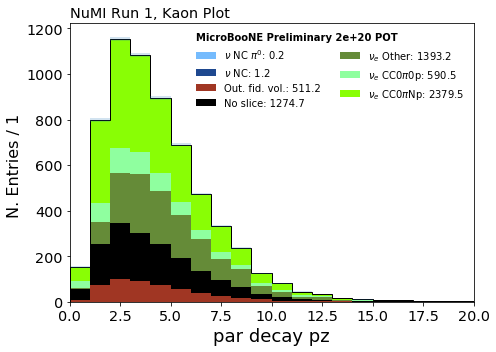

In [64]:
import matplotlib.pyplot as plt
import matplotlib
sysBool = True

VARIABLE, BINS, RANGE, XTIT ='par_decay_pz',20,(0,20.),"par decay pz"


fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL ,
    #kind="interaction",
    #kind="flux",
    draw_sys  = False, 
    draw_geoSys = False, 
    draw_data = False,
    ratio = False,
    genieweight = "weightSplineTimesTuneTimesPPFX", #"weightSplineTimesTuneTimesPPFX", 
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, Kaon Plot',loc='left')

fig.tight_layout()
#fig.savefig("/Users/elenag/Desktop/PlotterLEE/plots/NearSideband/allRecoE/CM/"+VARIABLE+"_NuMI_run1_mid.pdf")
#print('%s %.4f %.4f %.4f ' % (VARIABLE, my_plotter.stats['pvalue'], my_plotter.stats['pvaluestatonly'],my_plotter.stats['pvaluediag'])+"\n")
